In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

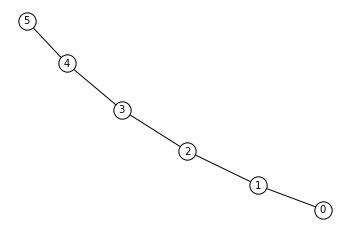

{'tag': 'NN(6)', 'total_vertices': 6, 'total_edges': 5, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [4, 5], [2, 3], [3, 4]], 'adjacency_hash': 'cb6075bc51cf31e074e89fe956468f6f'}
Greedy solution
 {0, 2, 4}
Chain strength: 4.0
[0.057662397816771224, 0.10379231607018821, 0.1268572751968967, 0.09225983650683398, 0.023064959126708494, 0.04612991825341699, 0.09225983650683398, 0.057662397816771224, 0.09225983650683398, 0.10379231607018821, 0.1268572751968967, 0.1268572751968967, 0.04612991825341699, 0.09225983650683398, 0.10379231607018821, 0.04612991825341699, 0.057662397816771224, 0.023064959126708494, 0.09225983650683398, 0.09225983650683398, 0.10379231607018821, 0.057662397816771224, 0.1268572751968967, 0.04612991825341699, 0.09225983650683398, 0.1268572751968967, 0.1268572751968967, 0.04612991825341699, 0.10379231607018821, 0.09225983650683398, 0.1268572751968967]
{'machine': 'DW_2000Q_5', 'settings': {'annealing_time': 500, 'answer_mode': 'histogram', 'auto_scale': True, 'num_reads'

In [2]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
# graph, tag = gt.generate_hamming_graph(1, 2)
# graph, tag = gt.generate_bipartite_graph(3, 3)
# graph, tag = gt.generate_newman_watts_strogatz_graph(10, 4, 0.1)
# graph, tag = gt.generate_corona_graph(3,6)
for nvertices in range(6, 7):
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))

    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))

    # Set chain strength
    chain_strength = maxJ * 2
    print(f"Chain strength: {chain_strength}")

    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)

    offsetcls = AnnealOffset("linear")
    
    qpu_graph = sampler.edgelist
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
    embed, embedding, min_offset, max_offset = retry_embedding(
        sampler, qubo_dict, qpu_graph, 10
    )
    anneal_offsets, exp_tag = find_offset(
        h=h,
        fcn=offsetcls.fcn,
        embedding=embedding,
        min_offset=min_offset,
        max_offset=max_offset,
    )
    print([i for i in anneal_offsets if i != 0])
    dwave_config = {
        "annealing_time": 500,  # integer microseconds [1, 2000]
        "answer_mode": "histogram",  # histogram or raw
        "auto_scale": True,
        "num_reads": 1000,  # raw will dump out all results
        "num_spin_reversal_transforms": 0,
        "readout_thermalization": 0,  # default 0
        "programming_thermalization": 1000,  # default 1000
        "chain_strength": chain_strength,
        "anneal_offsets": anneal_offsets,
    }
    solver = "DW_2000Q_5"

    experiment_params = experiment_summary(
        machine=solver,
        settings=dwave_config,
        penalty=penalty,
        chain_strength=chain_strength,
        tag=exp_tag,
    )
    print(experiment_params)

    # Solve on DWave and push to database
    result = embed.sample_qubo(qubo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    print(raw)
print("\nDONE")